# Predicting Newsletter Subscription Using Player Characteristics on a Minecraft Research Server

## Introduction

### Background

The Pacific Laboratory for Artificial Intelligence (PLAI) is a research group in Computer Science at UBC. PLAI manages a Minecraft server called PLAIcraft to study how players behave in a virtual world. As players interact with the environment, their actions and characteristics are recorded. The research group is interested in using this data to target recruitment efforts and ensure the server has adequate resources to handle player demand. Moreover, a particular focus is predicting which players will subscribe to a game-related newsletter, as subscribers may represent more engaged participants who are valuable for marketing opportunities or ongoing research. I chose to explore K-nearest neighbours (KNN) because it is a simple and interpretable classification method that works well when classifying binaray outcomes. 

### Question

**Can player characteristics (including age, total sessions, average session duration, and days active) predict newsletter subscription in the PLAIcraft dataset using a KNN classification model?**

The goal is to build a predictive model that identifies players that are most likely to subscribe for targeted recruitment and communication strategies.

---

## Data Description

This project uses two datasets collected automatically from player activity on the PLAIcraft server:

- **`players.csv`** — Contains player-level data including personal characteristics, total hours played, and whether they subscribed to the game newsletter.
- **`sessions.csv`** — Contains detailed records of individual gameplay sessions including start and end times for each session.

From these datasets, I also created summary features for each player like total sessions, average session duration, and days active.



### Players Dataset

- **Number of observations:** *196* players
- **Number of variables:** 7
- **Description:** Contains player characteristics, subscription status, and gameplay hours.

| Variable         | Type      | Meaning                                                                                                          | Summary Statistics (if applicable)                      |
|------------------|-----------|------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| `experience`      | character | The level of experience of the player (Beginner, Amateur, Regular, Veteran, Pro)                                 | N/A                                                      |
| `subscribe`       | logical   | Whether the player subscribed to the game newsletter (TRUE = subscribed, FALSE = not subscribed)                 | N/A                                                      |
| `hashedEmail`     | character | Anonymized unique identifier for each player                                                                     | N/A                                                      |
| `played_hours`    | double    | The total number of hours played by the player                                                                   | Min = 0, Max = 223.1, Mean = 5.85, Median = 0.1, SD = 28.36 |
| `name`            | character | The player's name                                                                                                | N/A                                                      |
| `gender`          | character | The player's gender (male, female, non-binary, agender, two-spirited, prefer not to say, other)                  | N/A                                                      |
| `age`             | double    | The player's age (years)                                                                                         | Min = 8, Max = 50, Mean = 20.52, Median = 19, SD = 6.17 |

---

### Sessions Dataset

- **Number of observations:** *1535* sessions 
- **Number of variables:** 5
- **Description:** Contains session level records of player activity.

| Variable               | Type      | Meaning                                                                              | Summary Statistics (if applicable) |
|------------------------|-----------|--------------------------------------------------------------------------------------|-------------------------------------|
| `hashedEmail`           | character | Anonymized unique identifier for each player                                         | N/A                                 |
| `start_time`            | string    | Standardized start time of the session (format: day-month-year hour:minute)          | N/A                                 |
| `end_time`              | string    | Standardized end time of the session (format: day-month-year hour:minute)            | N/A                                 |
| `original_start_time`   | string    | Original start time value recorded by the server                                     | N/A                                 |
| `original_end_time`     | string    | Original end time value recorded by the server                                       | N/A                                 |

---

### Aggregated Features (Derived from Sessions)

| Variable               | Type   | Meaning                                       | Summary Statistics (if applicable)                            |
| ---------------------- | ------ | --------------------------------------------- | ------------------------------------------------------------- |
| `total_sessions`       | double | Total number of sessions played by the player | Min = 0, Max = 310, Mean = 7.83, Median = 1, SD = 33.5        |
| `avg_session_duration` | double | Average session duration (minutes)            | Min = 0, Max = 150.34, Mean = 20.73, Median = 9.5, SD = 30.25 |
| `days_active`          | double | Number of unique days the player was active   | Min = 0, Max = 100, Mean = 3.92, Median = 1, SD = 13.9        |


---

### Issues identified

- **Played hours:** Highly skewed, a small number of players contribute very large amounts of data.
- **Categorical variables:** `experience` and `gender` will need encoding for machine learning.

---

### Potential unseen issues

- No activity captured outside PLAIcraft.
- Possible inaccuracies in self-reported fields like age or gender.
- Aggregation features which are derived from sessions may miss temporal patterns (ex. time-of-day effects).

---

### Data collection

- Data was collected automatically by PLAIcraft during normal gameplay.
- No manual data entry, all personal information is anonymized via hashed email.
- No external datasets merged.

---

## Methods & Results

### 1. Loading Data

First, we load the necessary libraries and read the players and sessions datasets from the project’s `data/` folder.

In [1]:
# Load required libraries
library(tidyverse)
library(repr)
library(lubridate)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read player and session data
players_raw <- read_csv("data/players.csv") 
sessions_raw <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## 2. Cleaning and wrangling the data into a tidy format

The data was cleaned and transformed to prepare it for analysis. I first standardized column names for consistency using `clean_names()`. I converted the `subscribe` variable into a factor to ensure it is treated as a categorical outcome for classification.

For the session data, I converted the `start_time` and `end_time` columns to date-time objects using `dmy_hm()`, and I additionally calculated the duration of each session in minutes.

Next, we summarized the session data for each player to calculate:
- **total_sessions**: the total number of sessions each player completed
- **avg_session_duration**: the mean duration of a player’s sessions (in minutes)
- **days_active**: the number of unique days a player was active on the server

Finally, I merged these session summaries with the player data. For players who had no session data, any missing values (NAs) in the session summaries were replaced with zeros. The resulting dataset combined player characteristics and gameplay behavior into one tidy dataframe with no missing values.



In [3]:
# Clean and standardize player data column names and convert "subscribe" to a factor
players <- players_raw |> 
    clean_names() |> 
    mutate(subscribe = as.factor(subscribe))

# Clean and standardize session data column names and compute session length in minutes
# Convert "start_time" and "end_time" to datetime format
sessions <- sessions_raw |> 
    clean_names() |> 
    mutate(
    starting_time = dmy_hm(start_time),
    ending_time = dmy_hm(end_time),
    session_length = as.numeric(ending_time - starting_time, units = "mins")
  )

# Summarize session data to calculate total sessions, average session duration, and active days per player
session_summary <- sessions |>
    group_by(hashed_email) |>
    summarise(total_sessions = n(),
    avg_session_duration = mean(session_length, na.rm = TRUE),
    days_active = n_distinct(as.Date(start_time)) 
  ) 

# Merge player data with session summaries and replace missing session values with zeros
player_summary <- players |>
    left_join(session_summary, by = "hashed_email") |>
    mutate(
    total_sessions = replace_na(total_sessions, 0),
    avg_session_duration = replace_na(avg_session_duration, 0),
    days_active = replace_na(days_active, 0)
    )

head(player_summary)

experience,subscribe,hashed_email,played_hours,name,gender,age,total_sessions,avg_session_duration,days_active
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,74.77778,18
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,85.00000,2
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,5.00000,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,50.00000,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,9.00000,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,0,0.00000,0


### Compute Overall Summary Statistics for Cleaned Data

To better understand the characteristics of the cleaned dataset, I computed overall summary statistics for key variables including `avg_session_duration`, `age`, `played_hours`, `total_sessions`, and `days_active`. This provides a general sense of the distribution and range of these variables across all players before performing further analysis.



In [4]:
# Compute overall summary statistics for cleaned data
player_summary_overall <- player_summary |>
  summarise(count = n(),

    min_avg_session_duration = min(avg_session_duration, na.rm = TRUE),
    max_avg_session_duration = max(avg_session_duration, na.rm = TRUE),
    mean_avg_session_duration = mean(avg_session_duration, na.rm = TRUE),
    median_avg_session_duration = median(avg_session_duration, na.rm = TRUE),
    sd_avg_session_duration = sd(avg_session_duration, na.rm = TRUE),

    avg_age = mean(age, na.rm = TRUE),
    median_age = median(age, na.rm = TRUE),
    sd_age = sd(age, na.rm = TRUE),
    min_age = min(age, na.rm = TRUE),
    max_age = max(age, na.rm = TRUE),

    avg_played_hours = mean(played_hours, na.rm = TRUE),
    median_played_hours = median(played_hours, na.rm = TRUE),
    sd_played_hours = sd(played_hours, na.rm = TRUE),
    min_played_hours = min(played_hours, na.rm = TRUE),
    max_played_hours = max(played_hours, na.rm = TRUE),

    avg_total_sessions = mean(total_sessions),
    median_total_sessions = median(total_sessions),
    sd_total_sessions = sd(total_sessions),
    min_total_sessions = min(total_sessions),
    max_total_sessions = max(total_sessions),

    avg_days_active = mean(days_active),
    median_days_active = median(days_active),
    sd_days_active = sd(days_active),
    min_days_active = min(days_active),
    max_days_active = max(days_active)
    )

player_summary_overall

count,min_avg_session_duration,max_avg_session_duration,mean_avg_session_duration,median_avg_session_duration,sd_avg_session_duration,avg_age,median_age,sd_age,min_age,⋯,avg_total_sessions,median_total_sessions,sd_total_sessions,min_total_sessions,max_total_sessions,avg_days_active,median_days_active,sd_days_active,min_days_active,max_days_active
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
196,0,150.3404,20.73429,9.5,30.2544,20.52062,19,6.174667,8,⋯,7.831633,1,33.48244,0,310,3.923469,1,13.92026,0,100


### Summary of the data relevant for exploratory data analysis

The dataset is prepared for exploratory analysis by selecting key variables: `subscribe`, `age`, `total_sessions`, `avg_session_duration`, and `days_active`. Next I compute summary statistics grouped by subscription status to see how these variables compare between subscribers and non-subscribers. This will help with my understanding of the data as we get ready to build and evaluate our model.




In [5]:
# Select relevant variables for exploratory data analysis
player_full <- player_summary |>
  select(subscribe, avg_session_duration, age, total_sessions, days_active)

# Compute summary statistics grouped by subscription status
player_summary_statistic <- player_summary |>
    group_by(subscribe) |>
    summarise(count = n(),

    min_avg_session_duration_sub = min(avg_session_duration, na.rm = TRUE),
    max_avg_session_duration_sub = max(avg_session_duration, na.rm = TRUE),
    mean_avg_session_duration_sub = mean(avg_session_duration, na.rm = TRUE),
    median_avg_session_duration_sub = median(avg_session_duration, na.rm = TRUE),
    sd_avg_session_duration_sub = sd(avg_session_duration, na.rm = TRUE),

    avg_age_sub = mean(age, na.rm = TRUE),
    median_age_sub = median(age, na.rm = TRUE),
    sd_age_sub = sd(age, na.rm = TRUE),
    min_ag_sub = min(age, na.rm = TRUE),
    max_age_sub = max(age, na.rm = TRUE),

    avg_total_sessions_sub = mean(total_sessions),
    median_total_sessions_sub = median(total_sessions),
    sd_total_sessions_sub = sd(total_sessions),
    min_total_sessions_sub = min(total_sessions),
    max_total_sessions_sub = max(total_sessions),

    avg_days_active_sub = mean(days_active),
    median_days_active_sub = median(days_active),
    sd_days_active_sub = sd(days_active),
    min_days_active_sub = min(days_active),
    max_days_active_sub = max(days_active)
    )

# View the summary table
player_summary_statistic

subscribe,count,min_avg_session_duration_sub,max_avg_session_duration_sub,mean_avg_session_duration_sub,median_avg_session_duration_sub,sd_avg_session_duration_sub,avg_age_sub,median_age_sub,sd_age_sub,⋯,avg_total_sessions_sub,median_total_sessions_sub,sd_total_sessions_sub,min_total_sessions_sub,max_total_sessions_sub,avg_days_active_sub,median_days_active_sub,sd_days_active_sub,min_days_active_sub,max_days_active_sub
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
FALSE,52,0,136.0000,16.85472,5.181818,30.04001,22.98077,21,8.166143,⋯,1.980769,1,6.634699,0,47,1.211538,1,2.865183,0,20
TRUE,144,0,150.3404,22.13525,10.500000,30.31320,19.61972,18,5.001748,⋯,9.944444,1,38.679385,0,310,4.902778,1,16.052065,0,100


### Visualizing the dataset relevant for exploratory data analysis

To explore how player characteristics differ between subscribers and non-subscribers, I create boxplots for key variables. Boxplots are useful for showing the median, spread, and existance of outliers for each variable by subscription status. This helps me see whether there are clear differences that could help the model predict subscription.


Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


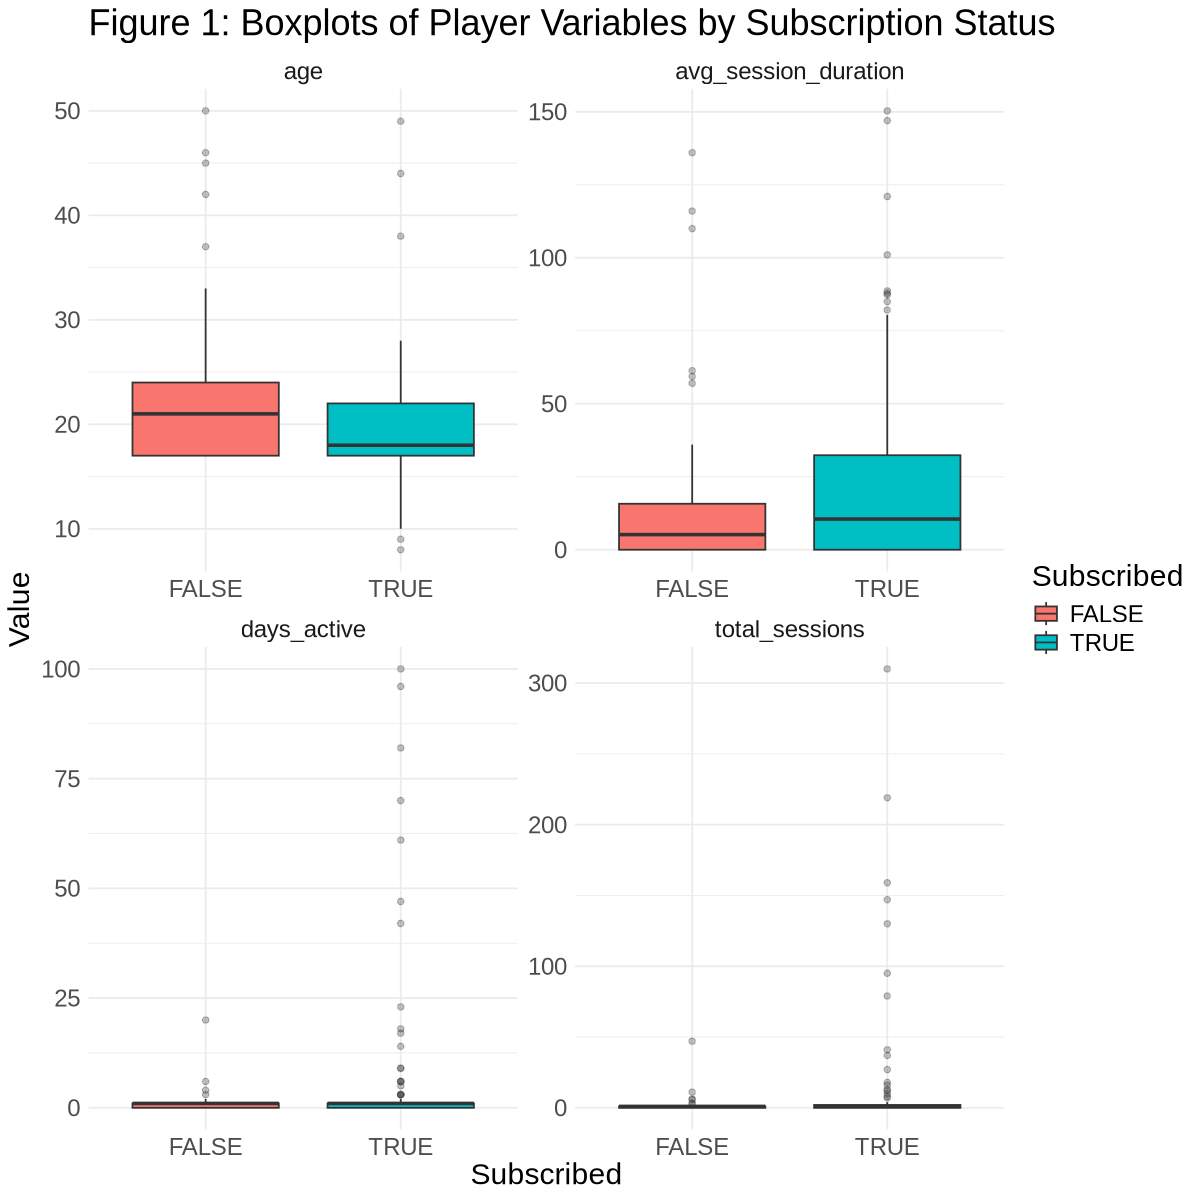

In [7]:
# Create boxplots comparing distributions of variables by subscription status
# Boxplots highlight medians, variability, and outliers
player_boxplot <- player_full |>
  pivot_longer(cols = c(age, total_sessions, avg_session_duration, days_active),
               names_to = "variable", values_to = "value") |>
  ggplot(aes(x = subscribe, y = value, fill = subscribe)) +
  geom_boxplot(outlier.alpha = 0.3) +
  facet_wrap(~ variable, scales = "free") +
  labs(
    title = "Figure 1: Boxplots of Player Variables by Subscription Status",
    x = "Subscribed",
    y = "Value",
    fill = "Subscribed"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 18))

#set plot size
options(repr.plot.height = 10, repr.plot.width = 10)

# View the boxplots
player_boxplot

**Insights:**  
From the boxplots and summary statistics, I observe that subscribers have lower average age compared to non-subscribers (mean age ≈ 19.6 vs. 23). This suggests that younger players may be more likely to subscribe. 

For gameplay behavior variables, subscribers have notably higher averages for `total_sessions` and `days_active`. Furthermore, the average total sessions for subscribers is about 9.94 compared to only 1.98 for non-subscribers. Similarly, the average days active is higher for subscribers (≈ 4.9) than non-subscribers (≈ 1.2). This indicates that more active players tend to subscribe.

However, the median values for these variables are quite low (often 1) for both groups, and the boxplots show very large overlap. This means that while some subscribers are much more active, there are many who are not, and many non-subscribers with similar activity levels to subscribers. 

There are also extreme outliers in `total_sessions` and `days_active`, where a small number of players contribute disproportionately large values. This could affect model training because those large values might make it harder to find patterns in the rest of the data.

Overall, while these variables show some association with subscription status, they are unlikely to be perfect predictors on their own. Combining them in a classification model may help improve predictive power.

---

## Data Analysis - K-Nearest Neighbors (KNN) Classification

I start my data analysis by setting the seed to ensure reproducibility of results. Then I split the dataset into training and testing sets using a 66:34 ratio. Stratified sampling is applied to maintain the proportion of subscribers and non-subscribers in both the training and testing data. This prepares the data for the creation of the KNN classification model.


In [ ]:
# Set seed for reproducibility
set.seed(25)
player_split <- initial_split(player_full, prop = 0.66, strata = subscribe)
    training_set <- training(player_split)
    testing_set <- testing(player_split)

**Tuning the KNN classification model:**

A KNN recipe is created that centers and scales all predictors so that numeric variables are on the same scale and contribute equally to distance calculations.

Next we defined a KNN model specification where the number of neighbors (`k`) is tuned. We used 3-fold cross-validation which is stratified by subscription status to reliably estimate accuracy for each value of `k`. Finally we collected the accuracy metrics across the different `k` values to select the best performing setting.



In [ ]:
#set plot size
options(repr.plot.height = 10, repr.plot.width = 10)


# Create KNN recipe that centers and scales all predictors 
knn_recipe <- recipe(subscribe ~., data = training_set) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())


# Define KNN model specification 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


# Set up 3-fold cross-validation stratified by subscription status
knn_vfold <- vfold_cv(training_set, v = 3, strata = subscribe)


# Define grid of k values 
k_vals = tibble(neighbors = seq(from = 1, to = 12, by = 1))


# Build workflow and tune number of neighbors using cross-validation and collect accuracy metrics
knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k_vals) |>
    collect_metrics()


# Filter results to keep only accuracy metrics
accuracies <- knn_results |>
    filter(.metric == "accuracy") 


# Plot accuracy estimates across different values of neighbors
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + geom_line() +
    labs(x = "Number of Neighbors (k)", y = "Accuracy Estimate (Proportion)", 
    title = "Figure 2: Cross-Validation Accuracy Across Different Neighbors") +  
    scale_x_continuous(breaks = seq(1, 12, by = 1)) +
    theme(text = element_text(size=18))  

cross_val_plot

# (Note to TA, A minor warning was produced which has no effect on model performance or results).

## Data Analysis Summary


#### Why is this method appropriate?


K-Nearest Neighbors (KNN) is appropriate for this classification task because it is a simple and interpretable method that classifies observations based on their distance to other data points. Since the goal is to predict a binary outcome (subscription status), KNN is a very valid choice. Centering and scaling predictors is especially important for KNN because it relies on distance calculations that can be distorted if variables are on different scales.

#### Which assumptions are required to apply this method?


KNN doesn't make many assumptions. However, it implicitly assumes that:
- The distance metrics are centered and scaled so that variables are on the same scale.
- Observations that have similar characteristics are likely to have the same class label.
- All predictors contribute equally.

#### What are the potential limitations or weaknesses of the method selected?


- KNN can be thrown off by variables that aren’t helpful as the algorithm gives all variables equal importance.
- KNN can have trouble if there are way more examples of one group because most neighbors will belong to that group.
- KNN can be slow when there is a lot of data because it has to store everything and measure distances each time it makes a prediction.

#### How did you compare and select the model?


3-fold cross-validation was used to estimate the accuracy for different values of `k` (from 1 to 12 neighbors) in the KNN model. The value of `k` with the highest average accuracy across the folds was selected as the best setting for the model. Cross-validation helps provide a non-biased estimate of model performance rather than relying on a single train/test split.`k = 7`  was chosen because it was the smallest value of `k` where accuracy reached its highest point. This gives us a model that is as simple as possible while still getting strong performance. Larger values of `k` were not chosen such as 9,10,11,12 because although they showed slightly higher accuracy, they could cause the model to underfit the data.


#### How did you process the data to apply the model?

I split the dataset into training and testing sets using a 66:34 training/testing ratio with stratified sampling based on subscription status. This ensured both training and testing sets maintained the class proportions of the original data. The data was split before tuning and model evaluation. I used cross-validation within the training set to tune the hyperparameter `k` and select the most optimal model. There was no separate validation set used because cross-validation provides this function internally.

---

#### Final Model Evaluation

After selecting k = 7 as the best setting from cross-validation, the final KNN model is fit on the training data and evaluated for its performance on the testing set. I generated predictions, performance metrics, and created a confusion matrix to better understand the model’s strengths and weaknesses.


In [ ]:
# Replace any remaining missing numeric values in the test set with 0
testing_set <- testing_set |>
  mutate(across(where(is.numeric), ~ replace_na(., 0)))

# Define final KNN model specification with k = 7
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

# Build workflow and fit final KNN model on training data
new_knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(new_knn_spec) |>
    fit(data = training_set)

# Generate predictions on the test set
knn_predictions <- predict(new_knn_fit, testing_set) |>
    bind_cols(testing_set)

head(knn_predictions)

Next, we calculated accuracy, precision, recall, and the confusion matrix to evaluate model performance.

In [ ]:
# Calculate accuracy 
knn_metrics <- knn_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

knn_metrics

In [ ]:
# Generate confusion matrix
knn_conf_mat <- knn_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class)

knn_conf_mat

In [ ]:
# Compute precision
knn_precision <- knn_predictions |>
  precision(truth = subscribe, estimate = .pred_class)

knn_precision

In [ ]:
# Compute recall
knn_recall <- knn_predictions |>
  recall(truth = subscribe, estimate = .pred_class)

knn_recall

## Discussion

#### Summary of what we found
The final KNN model with `k = 7` selected through cross-validation achieved an accuracy of approximately 76% on the test set. This means that the model correctly predicted subscription status for about three quarters(3/4) of the players in unseen data. The confusion matrix showed that the model had no false positives (precision of 1), meaning that whenever the model predicted a player would subscribe it was correct. The recall, however, was low (approximately 11%) indicating that the model missed a large number of actual subscribers. Most players were classified as subscribers and only a small number of non-subscribers were correctly identified. This shows that while the model was extremely cautious and precise, it was not able to identify all players who were truly subscribed.

#### Was this what we expected?
The results were somewhat in line with expectations. I anticipated that the KNN model would achieve reasonable accuracy given the simplicity of the predictors (age, total sessions, average session duration, and days active). I expected good precision because KNN with a higher `k` like 7 can be more careful about predicting positives. It only predicts a player is a subscriber when many of their neighbors are also subscribers, which helps reduce false positives. I did not expect recall to be so low. This suggests that the predictors available in our dataset do not provide enough separation between subscribers and non-subscribers for KNN to consistently identify all true subscribers. 

#### What impact could such findings have?
These findings demonstrate both the strengths and weaknesses of using KNN for predicting subscription status based on player characteristics and session data. The high precision is useful when the goal is to target only players who are very likely to subscribe, helping reduce wasted marketing effort when costs are high. However, the low recall means that many potential subscribers would be missed which could limit the reach of a recruitment or engagement campaign. While this model might not identify all subscribers, its selectiveness can be very valuable when it is more important to focus on fewer but highly certain potential subscribers.

In a real world setting, deploying this model would require continuous updating as player behavior patterns change over time. Ongoing monitoring would ensure that predictions remain valid as new players join the server.

#### What future questions could this lead to?
The results raise several important future questions that could guide further research: 

- **What would happen if we applied this model to a different game or server?**

- **How does the performance of KNN classification compare to other algorithms for subscription classification?** 

- **How might player preferences or motivations (e.g. interest in competitive play vs. creative building) affect subscription?**

All of these questions would be interesting to explore based on the results of this study.
